# PM2.5 Histogram (PM25 UART Logs)


This notebook loads a CSV produced by `pm25_uart_simpletest.py` and plots a frequency distribution (histogram) of the PM2.5 data.


Notes:


- The **first line** of the CSV is metadata (starts with `# meta,`), so we skip it when reading the table.
- The script logs both **pm25_standard** and **pm25_env**; we graph **pm25_env** by default.
- The `t_s` column is an integer timestamp (seconds since the script started).

In [9]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Point this to your CSV file (copied/pulled from the Raspberry Pi)
csv_path = pathlib.Path('pm25_data.csv')

# Read metadata line (optional)
with csv_path.open('r', encoding='utf-8') as f:
    meta_line = f.readline().strip()

print('Metadata:', meta_line)

# Load the actual CSV table (skips any comment/meta lines that start with '#')
df = pd.read_csv(csv_path, comment='#')
print('Columns:', list(df.columns))
df.head()

Metadata: # meta,start_epoch=1771024864,duration_s=30,interval_s=1,port=/dev/serial0
Columns: ['t_s', 'pm25_standard', 'pm25_env', 'pm10_standard', 'pm100_standard', 'particles_03um', 'particles_05um', 'particles_10um', 'particles_25um', 'particles_50um', 'particles_100um']


Metadata: # meta,start_epoch=1771024864,duration_s=30,interval_s=1,port=/dev/serial0
Columns: ['t_s', 'pm25_standard', 'pm25_env', 'pm10_standard', 'pm100_standard', 'particles_03um', 'particles_05um', 'particles_10um', 'particles_25um', 'particles_50um', 'particles_100um']


,t_s,pm25_standard,pm25_env,pm10_standard,pm100_standard,particles_03um,particles_05um,particles_10um,particles_25um,particles_50um,particles_100um
0,0,3,3,2,3,498,152,16,0,0,0
1,1,3,3,2,3,498,152,16,0,0,0
2,2,3,3,2,3,468,142,14,0,0,0
3,3,3,3,2,3,468,142,14,0,0,0
4,4,3,3,2,3,468,142,14,0,0,0


In [17]:
# Choose which PM2.5 column to histogram
col = 'pm25_env'  # or 'pm25_standard'

if col not in df.columns:
    raise KeyError(f"Column '{col}' not found. Available columns: {list(df.columns)}")

pm25 = pd.to_numeric(df[col], errors='coerce').dropna()
print('Count:', len(pm25))
print('Min/Max:', float(pm25.min()), float(pm25.max()))
print('Mean:', float(pm25.mean()))
print('Value counts:')
print(pm25.value_counts().sort_index())

Count: 30
Min/Max: 2.0 3.0
Mean: 2.6
Value counts:
pm25_env
2    12
3    18
Name: count, dtype: int64


In [28]:
# Quick sanity-check + interpretation based on the CSV values
counts = pm25.value_counts().sort_index()
total = int(counts.sum())

print(f'Sanity: {total} samples, {len(counts)} unique values')
for pm_value, n_samples in counts.items():
    frac = float(n_samples) / total if total else 0.0
    # Print the bin value directly to avoid float-casting issues
    print(f'  PM2.5={pm_value}: {int(n_samples)} samples ({frac:.0%})')

# This confirms what the histogram should show (bars at/near these values).

Sanity: 30 samples, 2 unique values
  PM2.5=2: 12 samples (40%)
  PM2.5=3: 18 samples (60%)


Saved histogram to: C:\Users\15593\Desktop\E11-Jack-James-Sam\E11_Jack_James_Sam\pm25_histogram_pm25_env.png


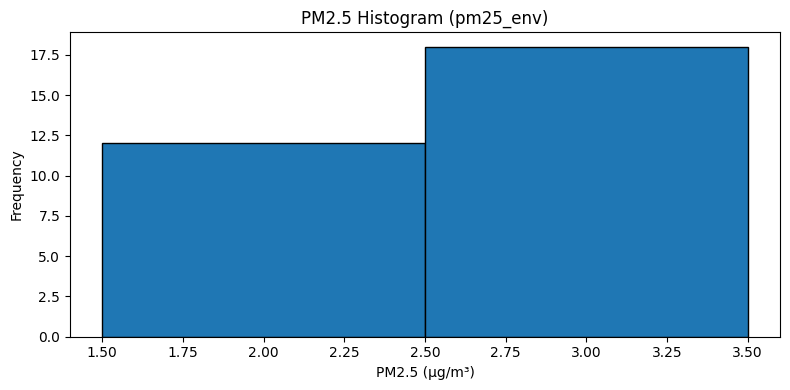

In [29]:
# Pick bin edges that look right for integer-ish sensor outputs; otherwise use numpy's auto bin edges.
pm25_values = pm25.to_numpy()
is_near_int = np.all(np.isclose(pm25_values, np.round(pm25_values), atol=1e-9))
if is_near_int and pm25.nunique() <= 50:
    lo = int(np.floor(pm25.min()))
    hi = int(np.ceil(pm25.max()))
    # centers bars on integers
    bin_edges = np.arange(lo - 0.5, hi + 1.5, 1)
else:
    bin_edges = np.histogram_bin_edges(pm25_values, bins='auto')

# Help linters/type checkers: matplotlib stubs accept Sequence[float], not NDArray
bin_edges_list = [float(x) for x in bin_edges.tolist()]

plt.figure(figsize=(8, 4))
plt.hist(pm25, bins=bin_edges_list, edgecolor='black')
plt.title(f'PM2.5 Histogram ({col})')
plt.xlabel('PM2.5 (µg/m³)')
plt.ylabel('Frequency')
plt.tight_layout()

# Save the plot next to the CSV (so it’s easy to submit/share)
out_path = csv_path.with_name(f'pm25_histogram_{col}.png')
plt.savefig(out_path, dpi=150)
print('Saved histogram to:', out_path.resolve())

plt.show()

## Anything interesting?

Using the data loaded above (`pm25_env`, 30 samples):

- The readings only take on **two values**: **2 µg/m³ (12 samples, 40%)** and **3 µg/m³ (18 samples, 60%)**.
- The histogram matches that: it shows **two bars** (bins 1.5–2.5 and 2.5–3.5) with heights 12 and 18.
